In [1]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
# from keras.applications import MobileNet
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam
import os.path
from keras.callbacks import EarlyStopping, ModelCheckpoint



Using TensorFlow backend.


In [2]:
base_model=MobileNetV2(input_shape=(224,224,3),weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

In [3]:
model=Model(inputs=base_model.input,outputs=preds)

In [4]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
    print(layer)
for layer in model.layers[20:]:
    layer.trainable=True

In [5]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory("./training_dataset/",
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 31590 images belonging to 2 classes.


In [6]:
earlystop = EarlyStopping(monitor='test_loss', patience=3, verbose=1)
# model.fit(x_train,y_train,batch_size=100,epochs=100, validation_data = (x_test, y_test),callbacks = [earlystop])

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=10,
                   callbacks = [earlystop])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
987/987 [==============================] - 356s 361ms/step - loss: 0.0429 - acc: 0.9907
Epoch 2/10


C:\Users\YF\Anaconda3\envs\tf-gpu\lib\site-packages\keras\callbacks.py:570: RuntimeWarning: Early stopping conditioned on metric `test_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


987/987 [==============================] - 306s 311ms/step - loss: 0.0176 - acc: 0.9945
Epoch 3/10
987/987 [==============================] - 311s 315ms/step - loss: 0.0358 - acc: 0.9923
Epoch 4/10
987/987 [==============================] - 306s 311ms/step - loss: 0.0174 - acc: 0.9943
Epoch 5/10
987/987 [==============================] - 313s 317ms/step - loss: 0.0130 - acc: 0.9952
Epoch 6/10
987/987 [==============================] - 302s 306ms/step - loss: 0.0193 - acc: 0.9941
Epoch 7/10
987/987 [==============================] - 334s 338ms/step - loss: 0.0130 - acc: 0.9950
Epoch 8/10
987/987 [==============================] - 315s 319ms/step - loss: 0.0105 - acc: 0.9954
Epoch 9/10
987/987 [==============================] - 303s 307ms/step - loss: 0.0373 - acc: 0.9923
Epoch 10/10
987/987 [==============================] - 312s 316ms/step - loss: 0.0219 - acc: 0.9948


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('on')
        plt.show()

    return img_tensor

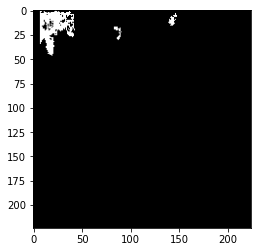

0

In [10]:
img_path = './train_data/abnormal/06f1a458-feb8-45e4-82c9-3340942244c3-DepBack-09_36_41.791-S10-W16.2.png'
new_image = load_image(img_path,show=True)
pred = model.predict(new_image)
predict=np.argmax(pred,axis=1)
maxindex = int(np.argmax(pred))
maxindex

In [132]:
normal_result = []
error_normal = []
path = "./train_data/normal/"

for image_file in os.listdir(path):

    new_image = load_image(path+image_file)
    pred = model.predict(new_image)
    predict=np.argmax(pred,axis=1)
    normal_result.append(predict[0])

print(normal_result.count(0))

2564


In [133]:
abnormal_result = []
error = []
path = "./train_data/abnormal/"

for image_file in os.listdir(path):
#     print(image_file)
    new_image = load_image(path+image_file)
    pred = model.predict(new_image)
    predict=np.argmax(pred,axis=1)
    abnormal_result.append(predict[0])
    if predict[0] == 0:
        error.append(image_file)


In [134]:
print(normal_result.count(1))
print(len(normal_result))
print(abnormal_result.count(1))
print(len(abnormal_result))

0
2564
0
845


In [135]:
model.save("mobile_v2_2.h5")

In [115]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
# model.evaluate_generator(generator=train_datagen,
#                          steps=900,
#                          verbose=1)